# Summary of findings from data Exploration : 


<u>Concerns with the initial dataset : </u>

1. There are 5000 duplicate values corresponding to user_id = 1048161 in the dataset (Need to drop duplicates before performing modelling)
2. In the dataset, `user_id`,`education_rank`,`marital-status`,`race`,`sex`,`works_hours`,`great_customer_class` have no NAs or nulls in them
- `mins_beerdrinking_year` has 7635 (88.8%) zeros	
- `mins_exercising_year` has 7850 (91.3%) zeros

3. `tea_per_year` and `coffee_per_year` have almost 17.6% of the values as Nulls. This is the highest fraction of nulls among all the columns in the dataset. For numerical variables like these, median imputation was followed.
4. Columns `workclass` and `occupation` both have 543 nulls. On analysis, it was found out that `workclass` is null whenever `occupation` is null - These nulls were replaced with the value 'unknown'
5. The categorical variables in the dataset were One-hot-encoded

<u>Important Findings :</u>
 
1. Most of the customers who are most profitable to the company are in the age range between 40-60.
2. More than 90% of the customers who are most profitable to the company are Married.

Hence `marital-status` = Married and `age` are some of the dominant factors to determine how profitable a customer can be to the company

3. `coffee_per_year` is positively correlated with `age` and `education_rank` and negatively correlated with `Salary`.
4. The data is highly imbalanced, and hence it is important to handle this imbalance (either by oversampling/undersampling)
5. There are 2 columns that have high cardinality (`education_rank` and `occupation`), and hence it is important to reduce the cardinality in these fields


Please feel free to browse through the notebook to understand more about my process of Data Exploration

# Import libraries and  dataset

In [13]:
# Import libraries
import pandas as pd
import logging
import json
from collections import namedtuple
import os
from pandas_profiling import ProfileReport
import seaborn as sns
import numpy as np

In [8]:
# Change directory to load data
os.chdir('../data')

In [9]:
data = pd.read_csv('final_dataset.csv')

In [10]:
data.head()

user_id   age workclass    salary  education_rank marital-status  \
0  1004889  14.0   private  70773.00               9  Never-married   
1  1012811  25.0   private  76597.00               9       Divorced   
2  1006870  21.0   private  47947.25              10  Never-married   
3  1022149  23.0   private  41740.25               7       Divorced   
4  1029558  26.0   private       NaN               9        Married   

  occupation           race     sex  mins_beerdrinking_year  \
0      sales  not_caucasian    Male                     0.0   
1      sales      caucasian  Female                     0.0   
2   clerical      caucasian  Female                     0.0   
3      sales      caucasian  Female                     0.0   
4      sales  not_caucasian    Male                     NaN   

   mins_exercising_year  works_hours  tea_per_year  coffee_per_year  \
0                   0.0           40         399.0              NaN   
1                   0.0           30         256.0              NaN   
2                   0.0           10         442.0            276.0   
3                   0.0           20           NaN              NaN   
4                   0.0           36           NaN            120.0   

   great_customer_class  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [16]:
data.describe()

user_id           age         salary  education_rank  \
count  1.359900e+04  13178.000000   13177.000000    13599.000000   
mean   1.033131e+06     44.842009   37149.297355       10.675417   
std    1.603004e+04     16.050574   24316.155119        2.224582   
min    1.000006e+06     14.000000    4872.750000        1.000000   
25%    1.019192e+06     30.000000   20885.500000        9.000000   
50%    1.038625e+06     50.000000   25912.750000       12.000000   
75%    1.048161e+06     59.000000   48908.750000       12.000000   
max    1.048839e+06     90.000000  363858.750000       16.000000   

       mins_beerdrinking_year  mins_exercising_year   works_hours  \
count            13175.000000          13178.000000  13599.000000   
mean               447.920607             46.034224     39.916317   
std               4782.134102            294.234126      9.839082   
min                  0.000000              0.000000      1.000000   
25%                  0.000000              0.000000     40.000000   
50%                  0.000000              0.000000     40.000000   
75%                  0.000000              0.000000     40.000000   
max              99999.000000           3900.000000     99.000000   

       tea_per_year  coffee_per_year  great_customer_class  
count  11170.000000     11188.000000          13599.000000  
mean     217.276544       359.708169              0.085889  
std      113.944411       164.680579              0.280210  
min        1.000000         1.000000              0.000000  
25%      175.000000       223.750000              0.000000  
50%      175.000000       447.000000              0.000000  
75%      276.000000       499.000000              0.000000  
max      499.000000       499.000000              1.000000

In [32]:
print(f"The shape of the dataframe is {data.shape}")

The shape of the dataframe is (13599, 15)


In [18]:
## Count of NA's in each column
data.isnull().sum(axis = 0)

user_id                      0
age                        421
workclass                  543
salary                     422
education_rank               0
marital-status               0
occupation                 543
race                         0
sex                          0
mins_beerdrinking_year     424
mins_exercising_year       421
works_hours                  0
tea_per_year              2429
coffee_per_year           2411
great_customer_class         0
dtype: int64

- It looks like `user_id`,`education_rank`,`marital-status`,`race`,`sex`,`works_hours`,`great_customer_class` have no NAs or nulls in them
- `tea_per_year` and `coffee_per_year` have almost 17.6% of the values as Nulls. This is the highest fraction of nulls among all the columns in the dataset.
- Columns `workclass` and `occupation` both have 543 nulls, which leads to the question : Are both the columns null for the same users?


In [28]:
### Columns workclass and occupation both have 543 nulls, which leads to the question : Are both the columns null for the same users?

data_wo = data[['user_id','workclass','occupation']]
data_wo[data_wo.workclass.isna() & data_wo.occupation.isna() ].shape

(543, 3)

The above analysis shows that Whenever `workclass` is null, then `occupation` is also null. Hence we can impute the nulls in these fields with 'null'

## Pandas Profiling report for Exploratory data Analysis


In [31]:
profile = ProfileReport(data, title='Pandas Profiling Report', explorative=True)
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Deductions from Pandas Profiling erport :
 
1. From pandas Profiling report, I was able to find out that There are 5000 duplicate values corresponding to user_id = 1048161 in the dataset
2. Salary and coffee_per_year are negatively correlated

In [37]:
data.drop_duplicates(inplace=True)
print(f"The shape of the dataframe after dropping duplicates is {data.shape}")

The shape of the dataframe after dropping duplicates is (8599, 15)


In [36]:

data.isnull().sum(axis = 0)

user_id                      0
age                        421
workclass                  543
salary                     422
education_rank               0
marital-status               0
occupation                 543
race                         0
sex                          0
mins_beerdrinking_year     424
mins_exercising_year       421
works_hours                  0
tea_per_year              2429
coffee_per_year           2411
great_customer_class         0
dtype: int64

Even after dropping duplicates, the number of nulls remain the same in all the columns

In [42]:
## Check the distribution of Class variable- Highly imbalanced Data
data.great_customer_class.value_counts()


0    7431
1    1168
Name: great_customer_class, dtype: int64

In [44]:
data.columns

Index(['user_id', 'age', 'workclass', 'salary', 'education_rank',
       'marital-status', 'occupation', 'race', 'sex', 'mins_beerdrinking_year',
       'mins_exercising_year', 'works_hours', 'tea_per_year',
       'coffee_per_year', 'great_customer_class'],
      dtype='object')

In [46]:
## Check the distribution of education_rank variable- High cardinality
data.education_rank.value_counts()

9     2957
10    1934
13    1285
14     398
11     385
7      341
6      283
12     273
4      178
5      140
15     108
8      104
3       90
16      70
2       42
1       11
Name: education_rank, dtype: int64

In [5]:
## Check the distribution of occupation variable- High cardinality
data.occupation.value_counts()

tech            5234
craft           1114
clerical         999
professional     984
service          973
executive        953
sales            920
factory          555
trucker          414
cleaner          399
farm             301
lawenf           161
estate_agent      47
soldier            2
Name: occupation, dtype: int64

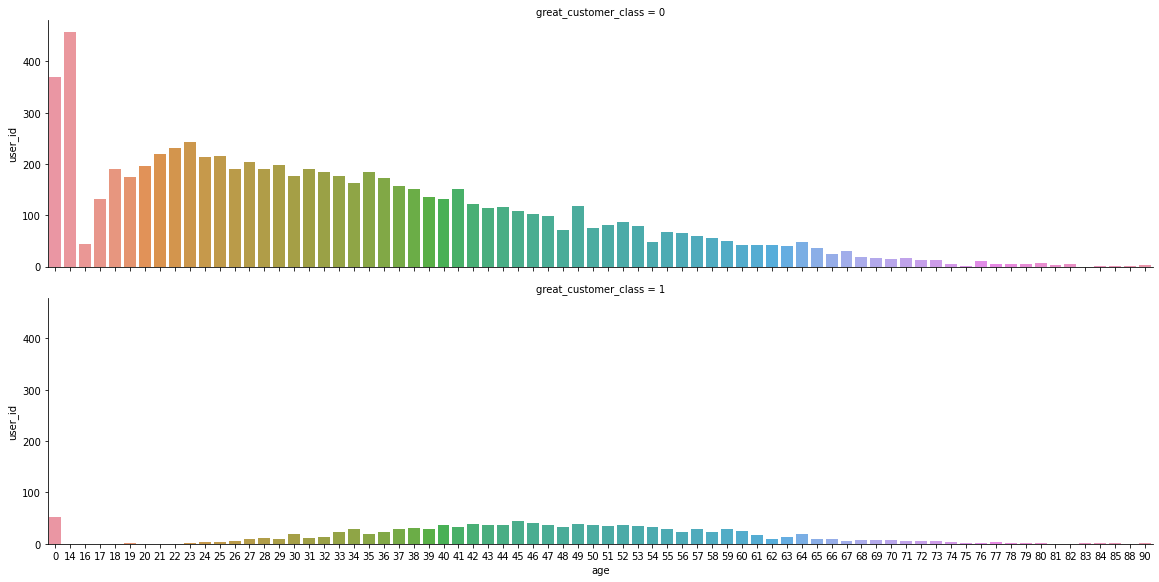

In [33]:
data.drop_duplicates(inplace=True)

data['age'] = data['age'].apply(lambda x : 0 if np.isnan(x) else int(x))
df_age = data.groupby(['age','great_customer_class'])['user_id'].count().reset_index()
#plt.figure(figsize=(4, 3))
g = sns.catplot(x="age",y="user_id",col="great_customer_class",col_wrap=1
                    ,data=df_age
                    ,orient="v",
                    kind='bar', height=4, aspect=4, legend=True)

Finding : 
Most of the customers who are most profitable to the company are in the age range between 40-60.

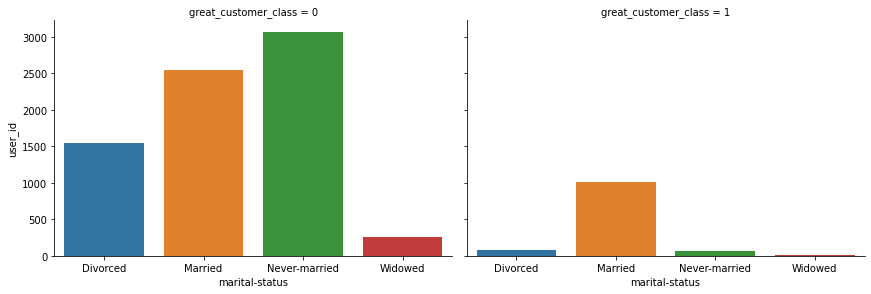

In [22]:
data.drop_duplicates(inplace=True)
df_marriage = data.groupby(['marital-status','great_customer_class'])['user_id'].count().reset_index()
#plt.figure(figsize=(4, 3))
g = sns.catplot(x="marital-status",y="user_id",col="great_customer_class",col_wrap=2
                    ,data=df_marriage
                    ,orient="v",
                    kind='bar', height=4, aspect=1.5, legend=True)

Finding : More than 90% of the customers who are most profitable to the company are Married